In [1]:
import os, sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).resolve().parents[1]))
sys.path.append(str(Path(os.getcwd()).resolve().parents[0]))

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data.sampler as torch_sampler
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from src.models.w2v2_aasist import W2VAASIST_AR
from src.datasets.dataset import MLAADFD_AR_Dataset

LOAD EXPERIMENT DATA AND TRAINED MODEL

In [3]:
EXP_DIR = Path("../../exp/trained_models/seg_preaug_subarc_k3/")

with open(EXP_DIR / "args.json", "r") as f:
    args = json.load(f)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = W2VAASIST_AR(
    feature_dim=args['feat_dim'], 
    num_labels=args['num_classes'] * args['k_centers'] if (args['k_centers'] > 1 and args['use_sub_center_arc_margin']) else args['num_classes'],
    extractor_model_class=args['model_class'],
    extractor_model_layer=args['model_layer'],
    extractor_hugging_face_path=args['hugging_face_path'],
    extractor_sampling_rate=args['sampling_rate'],
    normalize_before_output=True if (args['use_sub_center_arc_margin'] or args['use_arc_margin']) else False,
).to(device)

/home/woleek/ADAR/.venv/lib/python3.12/site-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [27]:
state = torch.load(EXP_DIR/'anti-spoofing_feat_model.pth', map_location=device, weights_only=True)

s = state.pop('arc_margin_scale', 1.0)
K = state.pop('arc_margin_k_centers', 1)

model.load_state_dict(state)

In [31]:
train_set = MLAADFD_AR_Dataset(
    path_to_dataset="../../"+args['path_to_dataset'], 
    empasizer_pre_augmented=args['pre_augmented'], 
    empasizer_sampling_rate=args['sampling_rate'], 
    empasizer_musan_path="../../"+args['musan_path'], 
    empasizer_rir_path="../../"+args['rir_path'], 
    part="train", 
    segmented=args['is_segmented']
)

dev_set = MLAADFD_AR_Dataset(
    path_to_dataset="../../"+args['path_to_dataset'], 
    empasizer_pre_augmented=args['pre_augmented'], 
    empasizer_sampling_rate=args['sampling_rate'], 
    empasizer_musan_path="../../"+args['musan_path'], 
    empasizer_rir_path="../../"+args['rir_path'], 
    part="dev", 
    mode="known", 
    segmented=args['is_segmented']
)

Searching for samples in folder: ../../data/prepared_ds_seg_aug/train
Found 55500 files...
Applied 1 emphases...
Resulting in 55500 samples...
Using 24 classes

Seen classes:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
Searching for samples in folder: ../../data/prepared_ds_seg_aug/dev
Found 24000 files...
Applied 1 emphases...
Resulting in 24000 samples...
Using 8 classes

Seen classes:  {4, 9, 10, 14, 17, 21, 22, 23}


In [32]:
train_loader = DataLoader(
    train_set,
    batch_size=args['batch_size'],
    shuffle=False,
    num_workers=args['num_workers'],
    sampler=torch_sampler.SubsetRandomSampler(range(len(train_set))),
    )

dev_loader = DataLoader(
    dev_set,
    batch_size=args['batch_size'],
    shuffle=False,
    num_workers=args['num_workers'],
    sampler=torch_sampler.SubsetRandomSampler(range(len(dev_set))),
)

In [42]:
@ torch.no_grad()
def run_inference(batch):
    feat, _, labels = batch
    
    if args['is_segmented']:
        n_segments = feat.shape[1]
        feat = feat.view(-1, args['sampling_rate'])
    
    feat = model.extract_features(feat)
    
    if args['is_segmented']:
        feat = feat.view(-1, n_segments, *feat.shape[1:])
        feat = feat.mean(dim=1)
    feat = feat.transpose(1, 2)
    labels = labels.to(device)

    feats, logits = model(feat)
    
    if args['use_sub_center_arc_margin']:
        # Aggregate sub-center outputs
        if K > 1:
            logits = torch.reshape(logits, (-1, args['num_classes'], K))
            logits, _ = torch.max(logits, axis=2)
            logits *= s # TODO: Check if this is correct
            
    elif args['use_arc_margin']:
        logits *= s # TODO: Check if this is correct
    
    scores = F.softmax(logits, dim=1)
    preds = torch.argmax(scores, dim=1)
    
    return feats, preds, labels

EVALUATE

In [43]:
train_embeddings = []
train_predictions = []
train_ground_truths = []

dev_embeddings = []
dev_predictions = []
dev_ground_truths = []

model.eval()

for batch in tqdm(train_loader, desc="Train"):
    feats, preds, labels = run_inference(batch)
    train_embeddings.append(feats.cpu())
    train_predictions.append(preds.cpu())
    train_ground_truths.append(labels.cpu())
    
for batch in tqdm(dev_loader, desc="Dev"):
    feats, preds, labels = run_inference(batch)
    dev_embeddings.append(feats.cpu())
    dev_predictions.append(preds.cpu())
    dev_ground_truths.append(labels.cpu())

Train:   0%|          | 0/434 [00:00<?, ?it/s]

Dev:   0%|          | 0/188 [00:00<?, ?it/s]

In [44]:
# Dimensionality reduction for visualization
def reduce_dimensions(embeddings, method="tsne"):
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Unsupported method. Use 'tsne'.")
    return reducer.fit_transform(embeddings)

In [45]:
train_embeds = torch.cat(train_embeddings)
dev_embeds = torch.cat(dev_embeddings)

In [46]:
train_embeds_2d = reduce_dimensions(train_embeds, method="tsne")
dev_embeds_2d = reduce_dimensions(dev_embeds, method="tsne")

In [47]:
# Visualization function
def plot_embeddings(embeddings, labels, title, n_per_class=None):
    plt.figure(figsize=(8, 8))
    for label in set(labels):
        indices = [i for i, l in enumerate(labels) if l == label]
        if n_per_class is not None and len(indices) > n_per_class:
            indices = indices[:n_per_class]
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=f"{label}", alpha=0.6)
    plt.title(title)
    plt.legend()
    
    # save plot
    plt.savefig(EXP_DIR / f"{title.lower().replace(' ', '_')}.png")
    
    plt.show()

In [48]:
train_gt = torch.cat(train_ground_truths)
dev_gt = torch.cat(dev_ground_truths)

train_preds = torch.cat(train_predictions)
dev_preds = torch.cat(dev_predictions)

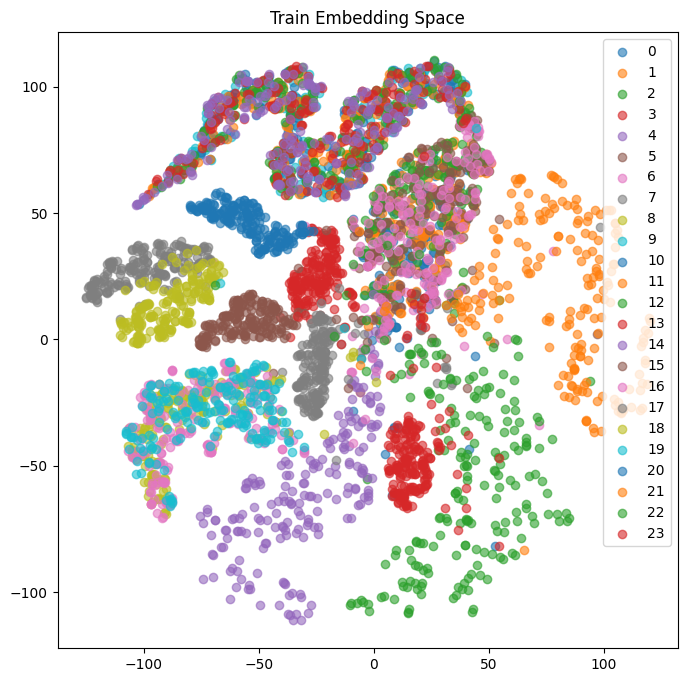

In [60]:
plot_embeddings(train_embeds_2d, train_gt.tolist(), "Train Embedding Space", n_per_class=200)

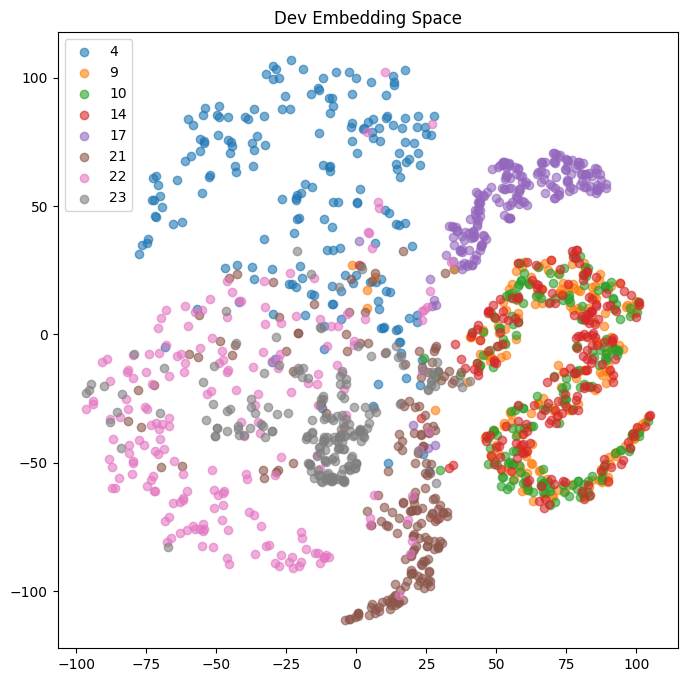

In [58]:
plot_embeddings(dev_embeds_2d, dev_gt.tolist(), "Dev Embedding Space", n_per_class=200)

In [53]:
print("Train Classification Report:")
print(classification_report(train_gt, train_preds, zero_division=0))

Train Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.01      0.02      1500
           1       0.25      0.94      0.40      1500
           2       0.00      0.00      0.00      1500
           3       0.90      0.90      0.90      1500
           4       0.84      0.99      0.91      7500
           5       0.00      0.00      0.00       770
           6       0.00      0.00      0.00       730
           7       0.94      0.91      0.92      1500
           8       0.00      0.00      0.00      1500
           9       0.00      0.00      0.00      1500
          10       0.00      0.00      0.00      1500
          11       0.00      0.00      0.00      1500
          12       0.00      0.00      0.00       770
          13       0.00      0.00      0.00       730
          14       0.20      0.99      0.34      1500
          15       0.98      0.90      0.94      1500
          16       0.00      0.00      0.00      150

In [54]:
print("Dev Classification Report:")
print(classification_report(dev_gt, dev_preds, zero_division=0))

Dev Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.85      0.88      0.86      7500
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00      1500
          10       0.00      0.00      0.00      1500
          14       0.33      0.92      0.49      1500
          15       0.00      0.00      0.00         0
          17       0.98      0.78      0.87      1500
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          21       0.58      0.72      0.64      1500
          22       0.86      0.72      0.79      7500
          23       0.75      0.51      0.61      1500
